In [1]:
import vit as vit
import utils
import visualize
import importlib
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
importlib.reload(vit)
image_size=512
model = vit.vit_b16(image_size, pretrained=True)

d:\insa\5if\KTH\P4\DL\Project\TransUnet\models\vit-keras\utils.py:84: UserWarning: Resizing position embeddings from 24 to 32
  UserWarning,
d:\insa\5if\KTH\P4\DL\Project\TransUnet\models\vit-keras\utils.py:200: UserWarning: Did not use the following weights: {'head/kernel', 'head/bias', 'cls'}
  f"Did not use the following weights: {unused}", UserWarning)


In [3]:
data = np.load("../../data/train_npz/case0007_slice085.npz")
image = data["image"]
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)

In [5]:
%%time 
y = model.predict(X)
y.shape

Wall time: 2.5 s


(1, 1024, 768)

In [13]:
patches = y.reshape((1, 1024, 16, 16, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


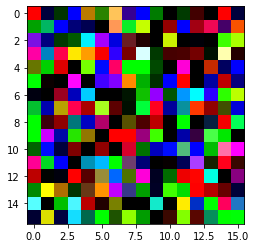

In [19]:
plt.imshow(patches[0, 60, :, :, :])

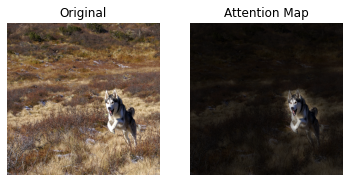

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load a model
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

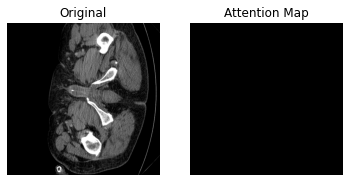

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Load a model
image_size = 512
model = vit.vit_b16(
    image_size=image_size,
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
data = np.load("../../data/train_npz/case0007_slice005.npz")
image = data["image"]
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
# X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map, cmap="viridis")